In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df = pd.read_csv('TimeSeries_TotalSolarGen_and_Load_IT_2016.csv')
df.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   utc_timestamp        8784 non-null   object 
 1   IT_load_new          8712 non-null   float64
 2   IT_solar_generation  8784 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 206.0+ KB


In [4]:
df['utc_timestamp'] = pd.to_datetime(df ['utc_timestamp'])
df.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01 00:00:00+00:00,21665.0,1
1,2016-01-01 01:00:00+00:00,20260.0,0
2,2016-01-01 02:00:00+00:00,19056.0,0
3,2016-01-01 03:00:00+00:00,18407.0,0
4,2016-01-01 04:00:00+00:00,18425.0,0


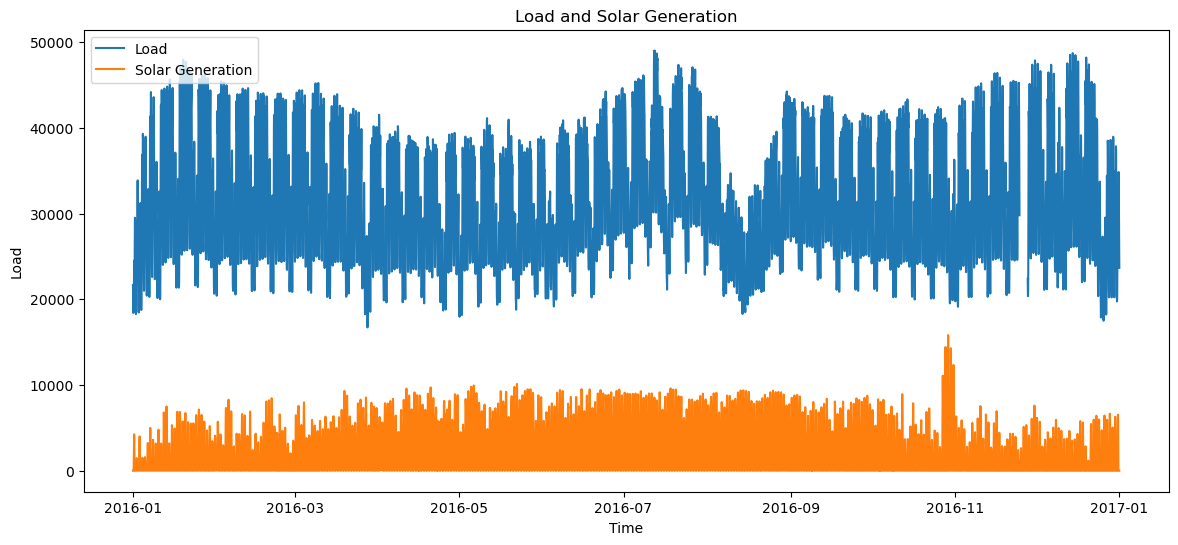

In [5]:
plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'], df['IT_load_new'], label='Load')
plt.plot(df['utc_timestamp'], df['IT_solar_generation'], label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.title('Load and Solar Generation')
plt.show()

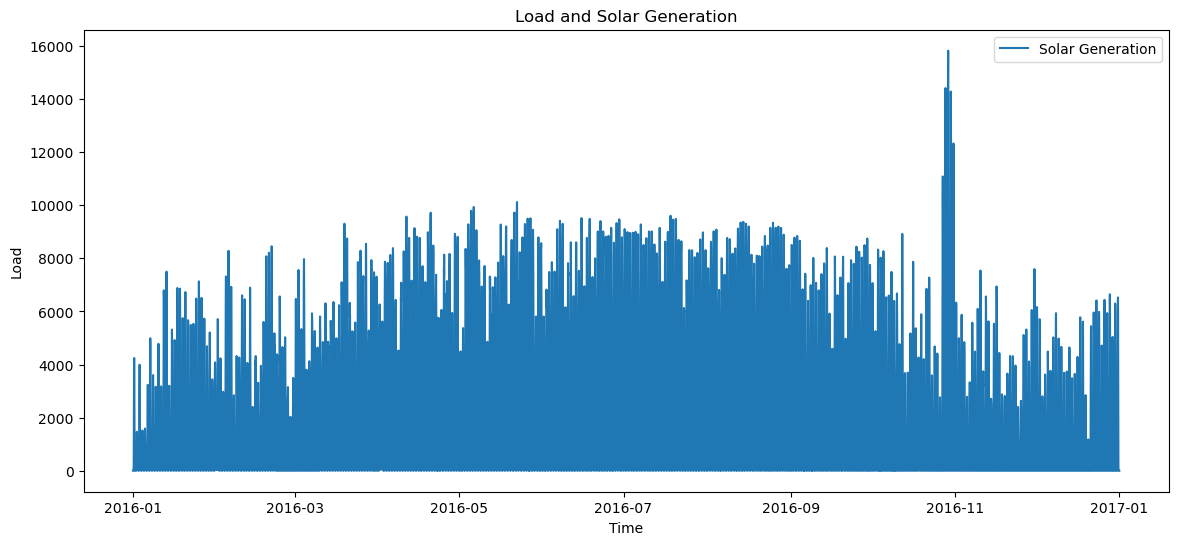

In [6]:
plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'], df['IT_solar_generation'], label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.title('Load and Solar Generation')
plt.show()

The plot shows both the load and solar generation over time for the year 2016. The load appears to have a cyclical pattern with peaks and valleys, possibly corresponding to daily patterns of electricity use.

The solar generation also shows a clear pattern, with generation during the day and no generation at night (as expected). The amount of solar generation also appears to fluctuate throughout the year, likely due to seasonal changes in sunlight.

Before moving on to time series analysis and forecasting with ARIMA, it's important to check for stationarity in your time series data. Stationarity is a property of time series data that implies the mean, variance, and autocorrelation structure do not change over time. Many time series models, including ARIMA, require the data to be stationary.

Let's perform an Augmented Dickey-Fuller test to check the stationarity of the time series. The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [7]:
# Checking Missing Values
df.isnull().sum()

utc_timestamp           0
IT_load_new            72
IT_solar_generation     0
dtype: int64

In [8]:
# Filling Missing Values
df['IT_load_new'].fillna(df['IT_load_new'].mean(), inplace=True)

# Again Checking Null Values
df.isnull().sum()

C:\Users\alokp\AppData\Local\Temp\ipykernel_39740\902813804.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['IT_load_new'].fillna(df['IT_load_new'].mean(), inplace=True)


utc_timestamp          0
IT_load_new            0
IT_solar_generation    0
dtype: int64

## Checking Stationarity


In [9]:
def adf_test(timeseries):
    print('Results Of Dickey-Fuller Test:')
    test_results = adfuller(timeseries)
    results = pd.Series(test_results[0:4], index=['Test Statics', 'p-Value', 'Lags Used', 'Number of Observations Used'])
    critical_values = test_results[4]
    for key, value in critical_values.items():
        results[f'Critical Value ({key})'] = value

    if results['p-Value'] <= 0.05:
        print("\nConclusion: Reject the Null Hypothesis (H0). The time series is likely stationary.")
    else:
        print("\nConclusion: Fail to Reject the Null Hypothesis (H0). The time series is likely non-stationary (it has a unit root).")
    print(results)

In [10]:
# ADF Test for IT_Load_New
adf_test(df['IT_load_new'])

Results Of Dickey-Fuller Test:

Conclusion: Reject the Null Hypothesis (H0). The time series is likely stationary.
Test Statics                  -1.192880e+01
p-Value                        4.835781e-22
Lags Used                      3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [11]:
# ADF Tets for IT_Solar_Generation
adf_test(df['IT_solar_generation'])

Results Of Dickey-Fuller Test:

Conclusion: Reject the Null Hypothesis (H0). The time series is likely stationary.
Test Statics                  -5.741335e+00
p-Value                        6.265438e-07
Lags Used                      3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


### From the Augmented Dickey-Fuller test:

For 'IT_load_new': The p-value is extremely small (much less than 0.05), so we reject the null hypothesis that the time series is non-stationary. Therefore, 'IT_load_new' can be considered stationary.

For 'IT_solar_generation': The p-value is also very small (much less than 0.05), so we reject the null hypothesis. This means 'IT_solar_generation' can be considered stationary as well.

Since both series are stationary, we can proceed with building an ARIMA model for each of them.

ARIMA, which stands for AutoRegressive Integrated Moving Average, is a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors. The equation can be used to forecast future values.

Any 'non-seasonal' time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

p is the order of the AR term (number of lags of Y to be used as predictors).
q is the order of the MA term (moving average).
d is the number of differencing required to make the time series stationary.
In our case, since the series are already stationary, d=0 for both series. We need to determine the optimal values for p and q. To do this, we'll look at the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots.

## Building ARIMA model for 'IT_Load_new'

In [12]:
# Splitting Data Into Training and Testing
train_size = int(len(df['IT_load_new']) * 0.8)
train, test = df['IT_load_new'][:train_size], df['IT_load_new'][train_size:]

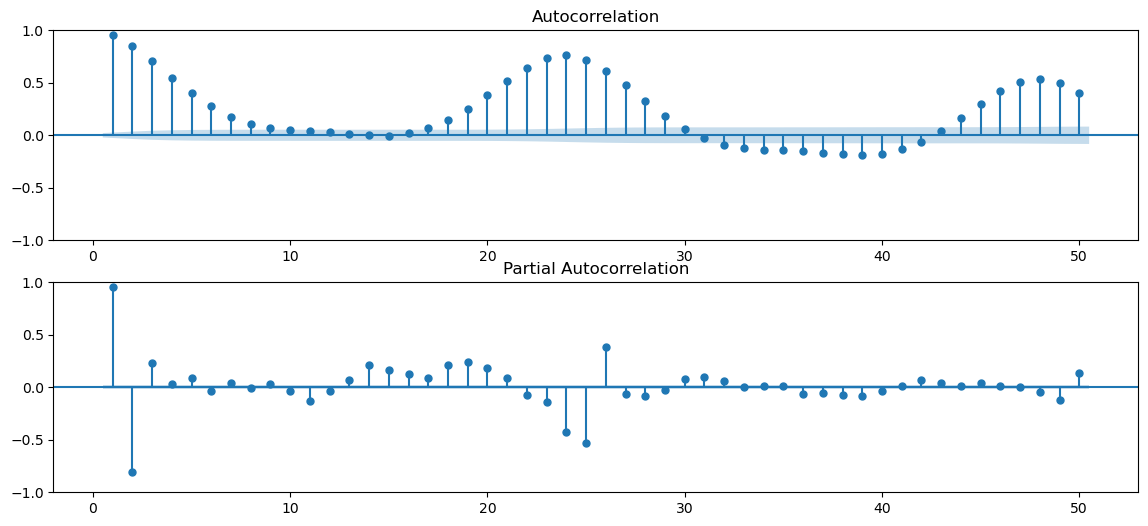

In [13]:
# Plot ACF and PACF

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))
plot_acf(df['IT_load_new'], lags=50, ax=ax1, zero=False)
plot_pacf(df['IT_load_new'], lags=50, ax=ax2, zero=False)
plt.show()

In [14]:
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()
prediction = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
rmse = sqrt(mean_squared_error(test, prediction))

print(round(rmse, 2))

7700.36


## Visualization Of Model

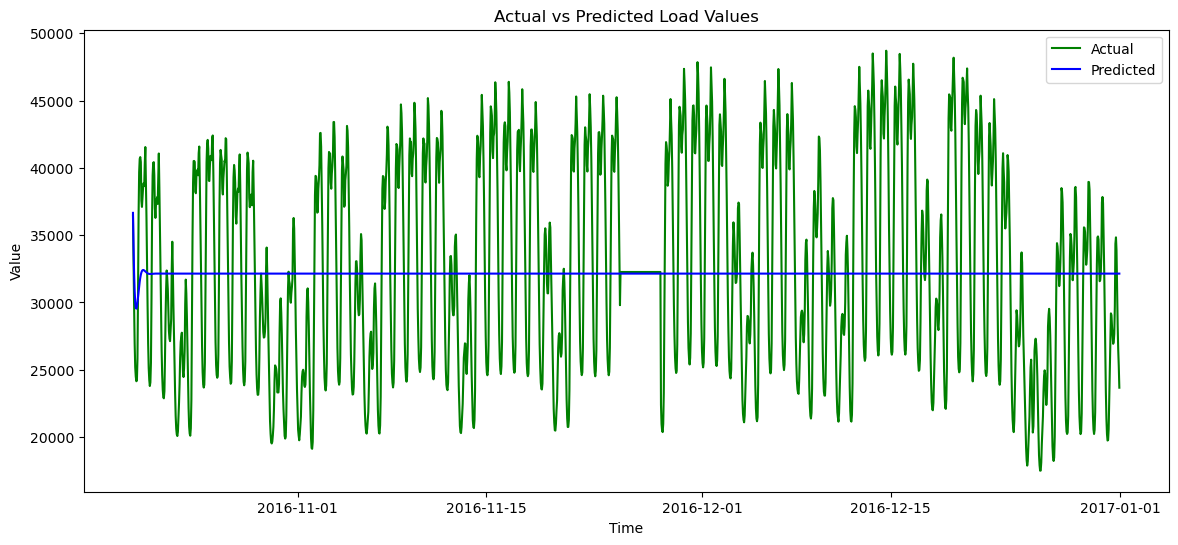

In [15]:
plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'][train_size:], test, label='Actual', color='green')
plt.plot(df['utc_timestamp'][train_size:], prediction, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

## Building Model for 'IT_Solar_Generation'

In [16]:
# Splitting Data Into Training and Testing
train_size = int(len(df['IT_solar_generation']) * 0.8)
train, test = df['IT_solar_generation'][:train_size], df['IT_solar_generation'][train_size:]

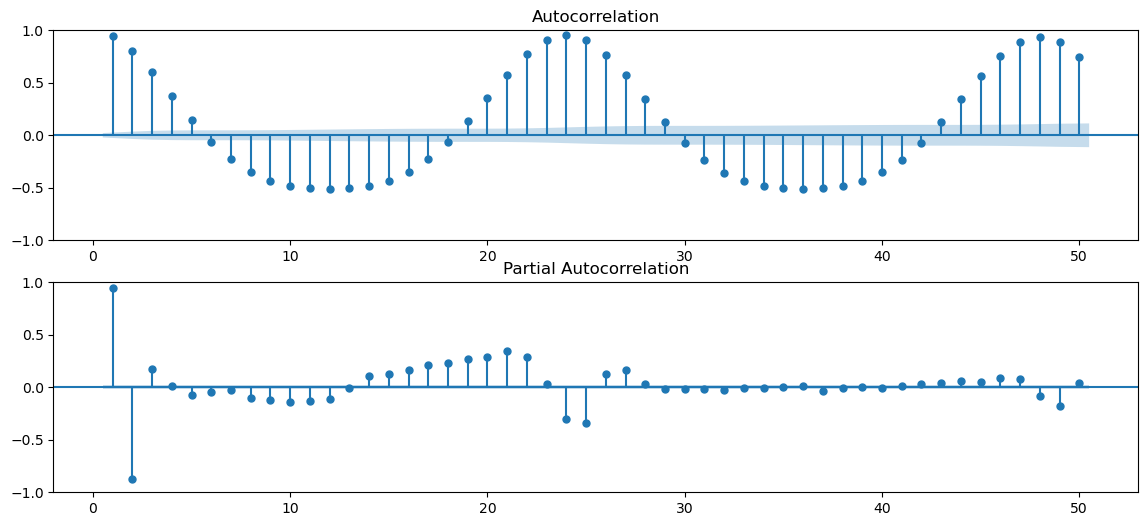

In [17]:
# Plot ACF and PACF

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))
plot_acf(df['IT_solar_generation'], lags=50, ax=ax1, zero=False)
plot_pacf(df['IT_solar_generation'], lags=50, ax=ax2, zero=False)
plt.show()

In [18]:
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()
prediction = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
rmse = sqrt(mean_squared_error(test, prediction))
print(round(rmse, 2))

2486.15


## Visualization of Model


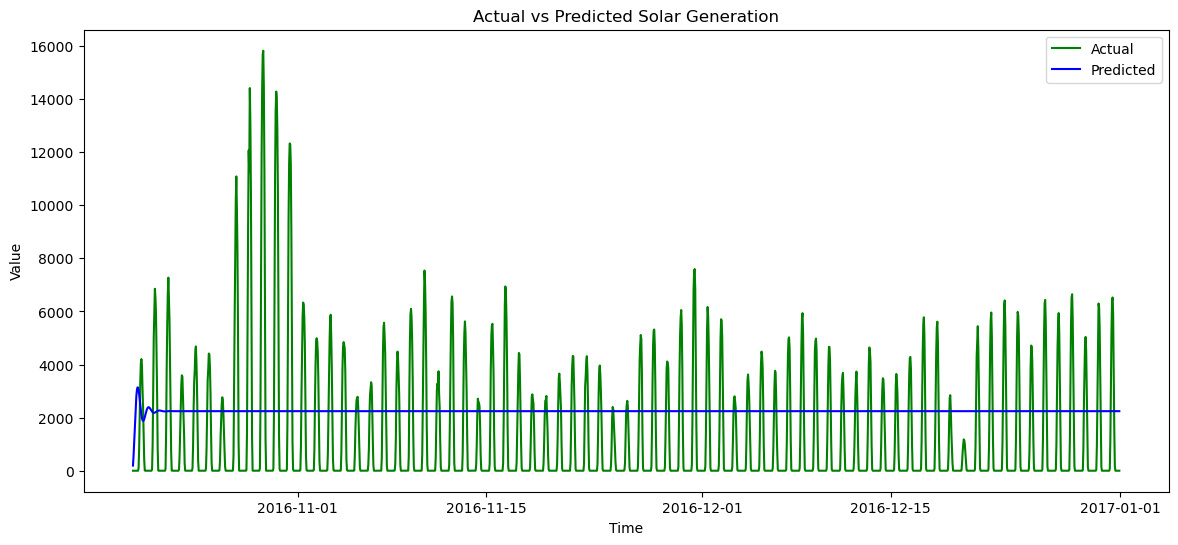

In [19]:
plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'][train_size:], test, label='Actual', color='green')
plt.plot(df['utc_timestamp'][train_size:], prediction, label='Predicted', color='blue')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Solar Generation')
plt.show()